<a href="https://colab.research.google.com/github/mpustil/DoctoradoPustilnik/blob/main/Modelos_SwiftV05_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Modelo 05: Imputacion + SVM (1/12/2025)

import pandas as pd
import numpy as np
import gc

'''
Archivos utilizados
Swift05_11SBS165.csv
https://drive.google.com/file/d/1T53fIqyrr70CHqXvB5lp0deJTxrfHUfV/view?usp=sharing
Swift05_11SBS52.csv
https://drive.google.com/file/d/1dQ5puACEkvwEE3zOl1vIrPglVQHXO7gD/view?usp=sharing

Swift11NoSBS.csv (solo registros sin flags de error)
https://drive.google.com/file/d/1-kSWbAy4ZL73eb6Wik3cei1s4iA1H1-j/view?usp=drive_link

'''
# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4']
  df[cols] = df[cols].applymap(np.int64)
  #variable target
  df['52'] = clase

  df.drop(['2', '112', '113', '114', '115'], axis=1, inplace=True)
  if clase == 1:
    #df.drop(['50','51','53'], axis=1, inplace=True)
    #Nos quedamos con el nombre
    df.drop(['50','51'], axis=1, inplace=True)
  else:
    df['53'] = ''

  # ponemos los NA
  listaVariables = ['110','111']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)

  #que tenga al menos uno de los filtros
  df = df[(df['110'] >= 0) | (df['111'] >=0 ) ]
  if clase == 0:
  #que no tenga flags
     df = df[(df['20'] == 0) & (df['21'] ==0 ) ]
     df.drop(['20','21'], axis=1, inplace=True)

  return df

dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')
dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)

#imputacion lineal (en datos sin resumir)
from sklearn.linear_model import LinearRegression
import math

#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

#Imputacion por regresion lineal
def regresionLineal(df):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  #print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  #print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  #print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")

  #print()
  #print(df.corr())
  df['111'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)

#imputacion por regresion lineal (en toda la base)
regresionLineal(dfSBS)
regresionLineal(dfNoSBS)

frames = [dfSBS, dfNoSBS]
df = pd.concat(frames)


/tmp/ipython-input-714854243.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-714854243.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)


In [ ]:
# Pre-procesamiento parte 2: submuestreo   (ya viene todo imputado!)

# importamos librerias para balancear los datos
from imblearn.under_sampling import RandomUnderSampler

#SMOTE (Synthetic Minority Over-sampling Technique)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE


# vamos a dejar un 10% de SBS (sampling_strategy = 0.1) y 90% NoSBS
#undersample = RandomUnderSampler(random_state=random_state, sampling_strategy = 0.1)

# vamos a dejar un 50% de SBS
undersample = RandomUnderSampler(random_state=random_state, sampling_strategy = 1.0)

#oversample = SMOTE(random_state=random_state)

# Separamos en X e y
X_SBS = df.drop(['52'], axis=1)
y_SBS = df['52']

#hacemos el submuestreo
X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)


# ahora hacemos el oversampling de las SBS
#X_over_SBS, y_over_SBS = oversample.fit_resample(X_over_SBS, y_over_SBS)

# preparamos todo para agrupar despues
df = X_over_SBS
df['52'] = y_over_SBS
dfSBS2 = df[(df['52'] == 1)]
dfNoSBS2 = df[(df['52'] == 0)]
dfSBS2.drop(['52'], axis=1,inplace= True)
dfNoSBS2.drop(['52'], axis=1,inplace= True)

print(len(dfSBS2), len(dfNoSBS2), len(X_over_SBS), len(df))


189 189 378 378


/tmp/ipython-input-4059710314.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSBS2.drop(['52'], axis=1,inplace= True)
/tmp/ipython-input-4059710314.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNoSBS2.drop(['52'], axis=1,inplace= True)


In [ ]:
# Agrupador prepM3b  (y submuestreo del modelo agrupado)

def desvio0(min, max, desvio)->float:
  ret = float('nan')
  if not math.isnan(min):
    ret = desvio
    if min == max:
      ret = 0.0
  return ret



#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3b(df, clase):

  #2: obsid, 4: fuente   mantenemos la fuente, para poder hacer el ranking
#   df = df.groupby(['4'],group_keys=True).agg(
  df = df.groupby(['4'],group_keys=True).agg(
      #count=('2','count'),  # cant obs

      SBS=('53', 'min'),
      min110=('110', 'min'),
      max110=('110', 'max'),
      mean110=('110', 'mean'),
      std110=('110', 'std'),

      min111=('111', 'min'),
      max111=('111', 'max'),
      mean111=('111', 'mean'),
      std111=('111', 'std'))

  #corregimos el desvio muestral (cuando hay 1 sola muestra)
  df['std110'] = df.apply(lambda x: desvio0(x['min110'],x['max110'],x['std110']), axis=1)
  df['std111'] = df.apply(lambda x: desvio0(x['min111'],x['max111'],x['std111']), axis=1)

  #variable target
  df['52'] = clase

  return df

dfSBS2 = prepM3b(dfSBS2,1)
dfNoSBS2 = prepM3b(dfNoSBS2,0)

print(len(dfNoSBS2),len(dfSBS2))


frames = [dfSBS2, dfNoSBS2]
df = pd.concat(frames)
# Separamos en X e y. Quitamos 'SBS'
X_SBS = df.drop(['52','SBS'], axis=1)
y_SBS = df['52']


#NoSBS:1885 SBS:48
print(len(X_SBS))


189 48
237


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_SBS,y_SBS, test_size=0.5, random_state= random_state)

# 2. Define the SVM model
svc = svm.SVC()

# 3. Define the parameter grid for the search
# The 'C' parameter is the regularization strength.
# The 'kernel' specifies the kernel type.
# The 'gamma' is the kernel coefficient for 'rbf', 'poly' and 'sigmoid' kernels.
param_grid = [
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [10, 1, 0.001, 0.0001], 'kernel': ['rbf']}
]

# 4. Perform Grid Search with cross-validation
# We use 5-fold cross-validation (cv=5) and set refit=True to train the best
# model on the entire dataset after the search is complete.
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring= 'f1_weighted', # # Or other metrics like 'accuracy', 'precision', 'recall'
    verbose=0,
    refit=True
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# 5. View Results
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score (f1_weighted): {:.3f}".format(grid_search.best_score_))


# Evaluate the best model on the held-out test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy with best model: {:.3f}".format(test_score))

Best hyperparameters found:  {'C': 1000, 'kernel': 'linear'}
Best cross-validation score (f1_weighted): 0.954
Test set accuracy with best model: 0.966


In [ ]:
#Metricas y Graficamos matriz de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def imprimirMetricas(mcTexto, mcGrafico, redondeo, best_clf):

  cm = confusion_matrix(y_test,y_test_pred_SBS,labels=best_clf.classes_)
  TN, FP, FN, TP = cm.ravel()
  #  (con las clases 1,0)
  if mcGrafico:
    ConfusionMatrixDisplay(cm, display_labels=np.flip(best_clf.classes_)).plot()

  # Calculo de las predicciones en Train y test
  y_train_pred = best_clf.predict(X_train)
  y_test_pred = best_clf.predict(X_test)


  print('El accuracy en train es:',round(accuracy_score(y_train,y_train_pred_SBS),redondeo))
  print('El accuracy en test es:', round(accuracy_score(y_test,y_test_pred_SBS),redondeo))

  #print(classification_report(y_test_SBS,y_test_pred_SBS))
  accu = (TP + TN) / (TP + FP + FN + TN)
  pres = TP / (TP + FP)
  rec = TP / (TP + FN)  # TP / (FN + TP)
  f1 = 2 * pres * rec / (pres + rec)

  print("Matriz de confusión")
  print("Predicho (1) (0)")
  print("Real(1) ",TP,"  ", FN)
  print("Real(0) ",FP,"  ", TN)

  print("Accuracy :  ", round(accu,redondeo))
  print("Precision : ", round(pres,redondeo))
  print("Recall :    ", round(rec,redondeo))
  print("F1 :        ", round(f1,redondeo))

best_clf = grid_search.best_estimator_

  # Predecimos Y
y_train_pred_SBS = best_clf.predict(X_train)
y_test_pred_SBS = best_clf.predict(X_test)

imprimirMetricas(True, False, 4, best_clf)


El accuracy en train es: 0.9576
El accuracy en test es: 0.9664
Matriz de confusión
Predicho (1) (0)
Real(1)  25    3
Real(0)  1    90
Accuracy :   0.9664
Precision :  0.9615
Recall :     0.8929
F1 :         0.9259


In [ ]:
#le agregamos los nombres de las SBS y la prediccion
X_test = X_test.merge(dfSBS2, how='left', on='4')

X_test.drop(['min110_y','min111_y','max110_y','max111_y','mean110_y','mean111_y','std110_y','std111_y'], axis=1, inplace=True)

X_test['pred'] = y_test_pred_SBS

soloSBS = X_test[X_test['SBS'].notna()]


In [ ]:
soloSBS.to_csv("SBSPredic.csv", sep=';', encoding='utf-8',index=False)

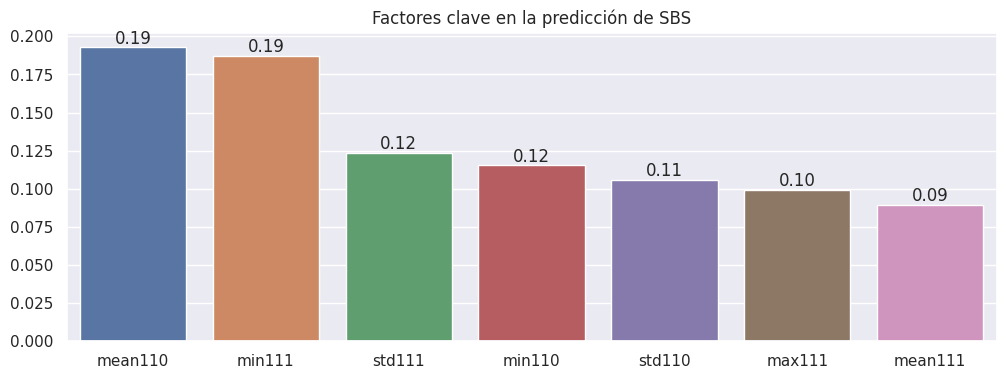

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=3,
                       n_estimators=30, random_state=41) instead.

<Figure size 1200x800 with 0 Axes>

In [ ]:
#importancia de atributos
#"112[2]:W1","113[3]:U","115[5]:V", "110[0]:W2","111[1]:M2""114[4]:B"

cantValMostrar = 7

feature_scores_SBS = pd.DataFrame(pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train_SBS.columns).sort_values(ascending=False).iloc[:cantValMostrar]).T

plt.figure(figsize=(12,4))
sns.barplot(data=feature_scores_SBS)

i = 0
for index, value in enumerate(feature_scores_SBS.values.flatten()):
    if i > cantValMostrar:
      break;
    i=i+1
    plt.annotate(f'{value:.2f}', xy=(index, value), ha='center', va='bottom')


plt.title("Factores clave en la predicción de SBS")
plt.show()

plt.figure(figsize = (12,8))

tree.plot_tree(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS));
tree.export_text(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS), feature_names=X_train_SBS.columns)



In [ ]:
#ojo, que guarda sin fuentes!
dfSBS.to_csv("Swift05_11SBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)
dfNoSBS.to_csv("Swift05_11NoSBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)